### Notebook documenting the multimodal modeling of UPPS impulsivity

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2,style='whitegrid')
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
import warnings

In [2]:
## all physiological measurements were obtained with 1 khz sampling freq (biopac?)
physio_fs = 1000

#### demographics data

In [3]:
#read age gender information provided in the LEMON dataset
age_gender_pd               = pd.read_csv('Data/META_File_IDs_Age_Gender_Education_Drug_Smoke_SKID_LEMON.csv')

#obtain average age for each provided range
age_gender_pd['avg_age']    = age_gender_pd['Age'].apply(lambda x: (int(x[0:2]) + int(x[3:5]))/2)
age_gender_pd['avg_age']    = age_gender_pd['Age'].apply(lambda x: (int(x[0:2]) + int(x[3:5]))/2)
age_gender_pd['ID']         = age_gender_pd['ID'].astype(str)

#renaming columns for better referencing
age_gender_pd = age_gender_pd.rename({'Gender_ 1=female_2=male':'Gender','ID':'subj'},axis=1)

In [4]:
age_gender_pd.head(n=2)

,subj,Gender,Age,Handedness,Education,DRUG,DRUG_0=negative_1=Positive,Unnamed: 7,Smoking,"Smoking_num_(Non-smoker=1, Occasional Smoker=2, Smoker=3)",...,SKID_Diagnoses 2,Comments_SKID_assessment,Hamilton_Scale,BSL23_sumscore,BSL23_behavior,AUDIT,Standard_Alcoholunits_Last_28days,Alcohol_Dependence_In_1st-3rd_Degree_relative,Relationship_Status,avg_age
0,sub-010017,2,20-25,right,Gymnasium,negative,0.0,NaN,non-smoker,1.0,...,NaN,NaN,0.0,NaN,NaN,12.0,47,No,No,22.5
1,sub-010015,2,20-25,right,Gymnasium,negative,0.0,NaN,occasional smoker,2.0,...,NaN,NaN,0.0,NaN,NaN,12.0,45,Yes,Yes,22.5


#### The number of male and female participants in the dataset: 1=female_2=male

In [5]:
age_gender_pd.Gender.value_counts()

Gender
2    145
1     82
Name: count, dtype: int64

#### Average age of the participants

In [6]:
age_gender_pd.avg_age.mean(), age_gender_pd.avg_age.std()

(39.19603524229075, 20.260693279741066)

### load upps data - precomputed from the distributed UPPS data

In [7]:
upps_pd = pd.read_csv('Data/mmodal_upps.csv',index_col=0)
upps_pd.head()

,ID,UPPS_urgency,UPPS_lack_premeditation,UPPS_lack_perseverance,UPPS_sens_seek,subj
0,sub-010017,27.0,26.0,22.0,39.0,sub-010017
1,sub-010015,28.0,28.0,32.0,29.0,sub-010015
2,sub-010100,19.0,19.0,16.0,34.0,sub-010100
3,sub-010003,25.0,22.0,20.0,27.0,sub-010003
4,sub-010022,26.0,25.0,25.0,31.0,sub-010022


In [8]:
#number of columns used to compute score for each subscale in UPPS, used for plotting min/max range
quest_cols_numquest = {'UPPS_urgency':12,
 'UPPS_lack_premeditation':11,
 'UPPS_lack_perseverance':10,
 'UPPS_sens_seek':12}

#### plot the distribution of the impulsivity scores

(10.0, 50.0)

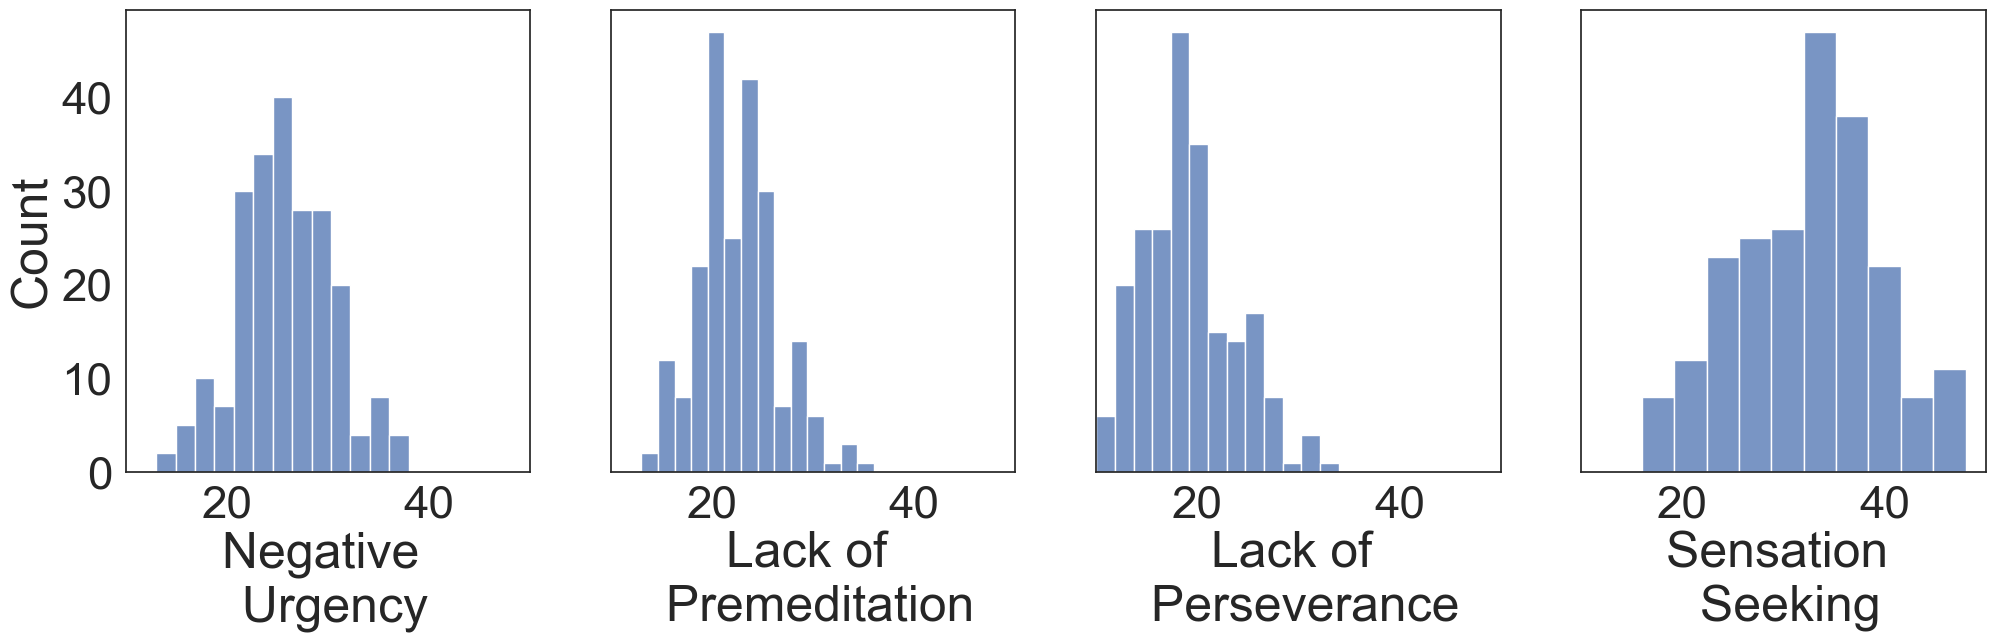

In [9]:
sns.set(font_scale=3,style='white')
fig, ax = plt.subplots(1,4,figsize=(24,6),sharey=True,sharex=True)
sns.histplot(upps_pd['UPPS_urgency'],ax=ax[0])
ax[0].set_xlabel('Negative \n Urgency')
sns.histplot(upps_pd['UPPS_lack_premeditation'],ax=ax[1])
ax[1].set_xlabel('Lack of \n Premeditation')
sns.histplot(upps_pd['UPPS_lack_perseverance'],ax=ax[2])
ax[2].set_xlabel('Lack of \n Perseverance')
sns.histplot(upps_pd['UPPS_sens_seek'],ax=ax[3])
ax[3].set_xlabel('Sensation \n Seeking')

plt.xlim(10, 50)

### load behavioral data - obtained from the scores distributed in the LEMON dataset for the TAP-I tests
The TAP-I tests are in the 'Cognitive_Test_Battery_LEMON' folder of LEMON dataset
In TAP_I_15, TAP_I_20: #15 and 20 are average response time and total error for entirety of trial for TAP I tests

In [10]:
behav_pd = pd.read_csv('Data/mmodal_behav.csv',index_col=0)

In [11]:
behav_pd.head(n=2)

,ID,TAP_I_meanRxTime,TAP_I_totalErr,subj
0,sub-010017,361,4,sub-010017
1,sub-010015,547,3,sub-010015


### load physiological data

HRV features are obtained from the distributed PPG signal in the lemon dataset using the beat_detector_pantompkins routine

#### The relevant notebook for this data preparation can be found in helper_notebook/compute_ppghrv.ipynb

In [12]:
all_physio_feat_mean_pd = pd.read_csv('Data/mmodal_physiomean.csv',index_col=0)

### load neurobiological data

#### ACC connectivity obtained from the fMRI data in lemon. Refer to helper_notebook/compute_ConnROITimeseries.ipynb
to create connectivity features from the brain ROI defined by the CONN atlas

In [13]:
all_conn_pd     = pd.read_csv('Data/mmodal_neuro_ConnAtlas_ACC.csv',index_col=0)

In [14]:
all_conn_pd.shape

(212, 164)

In [15]:
all_conn_pd.head(n=2)

,"ACC-AC (Cingulate Gyrus, anterior division)",ACC-AG l (Angular Gyrus Left),ACC-AG r (Angular Gyrus Right),ACC-Accumbens l,ACC-Accumbens r,ACC-Amygdala l,ACC-Amygdala r,ACC-Brain-Stem,ACC-CO l (Central Opercular Cortex Left),ACC-CO r (Central Opercular Cortex Right),...,"ACC-pSTG r (Superior Temporal Gyrus, posterior division Right)","ACC-pTFusC l (Temporal Fusiform Cortex, posterior division Left)","ACC-pTFusC r (Temporal Fusiform Cortex, posterior division Right)","ACC-sLOC l (Lateral Occipital Cortex, superior division Left)","ACC-sLOC r (Lateral Occipital Cortex, superior division Right)","ACC-toITG l (Inferior Temporal Gyrus, temporooccipital part Left)","ACC-toITG r (Inferior Temporal Gyrus, temporooccipital part Right)","ACC-toMTG l (Middle Temporal Gyrus, temporooccipital part Left)","ACC-toMTG r (Middle Temporal Gyrus, temporooccipital part Right)",subj
0,-0.191741,0.748506,0.467789,-0.356228,-0.298597,0.163889,0.220606,-0.030221,-0.441537,-0.369531,...,-0.286095,0.318162,-0.011868,0.780759,0.095013,0.401224,0.115689,0.378347,0.616825,sub-010002
1,0.469206,0.697674,0.541601,0.323375,0.240584,0.484925,0.453499,0.483386,-0.067269,0.235591,...,0.432744,0.619608,0.416319,0.828080,0.421521,0.480976,0.116343,0.732011,0.431228,sub-010003


### all features

In [16]:
all_upps_cols = ['UPPS_urgency', 'UPPS_lack_premeditation',
                       'UPPS_lack_perseverance', 'UPPS_sens_seek']

all_behav_feat = ['TAP_I_meanRxTime','TAP_I_totalErr']

all_hrv_feat   = ['bpm','sdnn', 'rmssd', 'pnn50', 'pnn20', 'sd1','sd2','sd1/sd2']

all_neuro_feat = list(np.setdiff1d(all_conn_pd.columns.values,['subj']))

### Correlates in different modalities

In [17]:
print('Behav pd {}, upps shape{}'.format(behav_pd.shape, upps_pd.shape))
behav_upps_pd = behav_pd.merge(upps_pd,on='subj').dropna()
print('Combined: {}'.format(behav_upps_pd.shape))

param_quest_corr = {}

for behav_cols in all_behav_feat:
    param_corr = {}
    for each_quest_col in all_upps_cols:
        param_values    = behav_upps_pd[behav_cols]
        quest_values    = behav_upps_pd[each_quest_col]    
        corr_val, corr_p = pearsonr(param_values,quest_values)
        param_corr[each_quest_col] = str(np.round(corr_val,2)) + ' (p=' + str(np.round(corr_p,4)) + ')' 
        
    param_quest_corr[behav_cols] = param_corr.copy()
    
param_quest_corr_pd = pd.DataFrame(param_quest_corr)

param_quest_corr_pd

Behav pd (227, 4), upps shape(227, 6)
Combined: (220, 9)


,TAP_I_meanRxTime,TAP_I_totalErr
UPPS_urgency,-0.05 (p=0.4541),0.03 (p=0.6072)
UPPS_lack_premeditation,-0.08 (p=0.2344),0.07 (p=0.2804)
UPPS_lack_perseverance,-0.13 (p=0.0536),-0.05 (p=0.4441)
UPPS_sens_seek,-0.4 (p=0.0),-0.04 (p=0.5921)


In [18]:
print('hrv pd {}, upps shape{}'.format(all_physio_feat_mean_pd.shape, upps_pd.shape))
hrv_upps_pd = all_physio_feat_mean_pd.merge(upps_pd,on='subj').replace(np.inf,np.nan).dropna()
print('Combined: {}'.format(hrv_upps_pd.shape))

param_quest_corr = {}

for hrv_cols in all_hrv_feat:
    param_corr = {}
    for each_quest_col in all_upps_cols:
        param_values    = hrv_upps_pd[hrv_cols]
        quest_values    = hrv_upps_pd[each_quest_col]    
        corr_val, corr_p = pearsonr(param_values,quest_values)
        param_corr[each_quest_col] = str(np.round(corr_val,2)) + ' (p=' + str(np.round(corr_p,4)) + ')' 
        
    param_quest_corr[hrv_cols] = param_corr.copy()
    
param_quest_corr_pd = pd.DataFrame(param_quest_corr)

param_quest_corr_pd

hrv pd (262, 15), upps shape(227, 6)
Combined: (177, 20)


,bpm,sdnn,rmssd,pnn50,pnn20,sd1,sd2,sd1/sd2
UPPS_urgency,0.11 (p=0.1414),0.06 (p=0.3993),-0.01 (p=0.8558),0.0 (p=0.9474),0.06 (p=0.4525),-0.01 (p=0.9061),0.05 (p=0.5298),-0.03 (p=0.6739)
UPPS_lack_premeditation,-0.01 (p=0.9008),0.02 (p=0.783),0.01 (p=0.9232),-0.02 (p=0.7418),0.02 (p=0.8273),0.0 (p=0.9926),0.02 (p=0.7812),-0.16 (p=0.038)
UPPS_lack_perseverance,0.09 (p=0.219),0.08 (p=0.2775),-0.06 (p=0.463),-0.06 (p=0.4493),0.05 (p=0.5212),-0.06 (p=0.4596),0.09 (p=0.2405),-0.21 (p=0.0049)
UPPS_sens_seek,-0.22 (p=0.0035),0.07 (p=0.3647),0.13 (p=0.0746),0.16 (p=0.0365),0.28 (p=0.0001),0.14 (p=0.0697),0.09 (p=0.2136),-0.15 (p=0.0483)


In [19]:
print('fMRI conn pd {}, upps shape{}'.format(all_conn_pd.shape, upps_pd.shape))
conn_upps_pd = all_conn_pd.merge(upps_pd,on='subj').replace(np.inf,np.nan).dropna()
print('Combined: {}'.format(conn_upps_pd.shape))

param_quest_corr = {}

for each_quest_col in all_upps_cols:
    print('==== Impuls: {}'.format(each_quest_col))
    param_corr = {}
    for fmri_feat in all_neuro_feat:
        param_values    = conn_upps_pd[fmri_feat]
        quest_values    = conn_upps_pd[each_quest_col]    
        corr_val, corr_p = pearsonr(param_values,quest_values)
        param_corr[fmri_feat] = str(np.round(corr_val,2)) + ' (p=' + str(np.round(corr_p,2)) + ')' 
        
        if(corr_p < 0.05/163): #103/163 because of the number of fMRI features considered in ACC- connectivity in AAL/oxford atlas
            print(fmri_feat,corr_val,corr_p)
        
    param_quest_corr[each_quest_col] = param_corr.copy()
    
param_quest_corr_pd = pd.DataFrame(param_quest_corr)

param_quest_corr_pd

fMRI conn pd (212, 164), upps shape(227, 6)
Combined: (205, 169)
==== Impuls: UPPS_urgency
==== Impuls: UPPS_lack_premeditation
ACC-pMTG r (Middle Temporal Gyrus, posterior division Right) -0.2740457045562856 7.00448420067198e-05
==== Impuls: UPPS_lack_perseverance
==== Impuls: UPPS_sens_seek
ACC-Cereb2 l (Cerebelum Crus2 Left) -0.27839795866697437 5.302526579800574e-05


/Users/lbishal/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,UPPS_urgency,UPPS_lack_premeditation,UPPS_lack_perseverance,UPPS_sens_seek
"ACC-AC (Cingulate Gyrus, anterior division)",0.05 (p=0.46),0.07 (p=0.33),0.07 (p=0.31),0.0 (p=0.95)
ACC-AG l (Angular Gyrus Left),0.04 (p=0.58),-0.13 (p=0.06),-0.03 (p=0.68),-0.09 (p=0.19)
ACC-AG r (Angular Gyrus Right),0.0 (p=0.98),-0.16 (p=0.02),-0.05 (p=0.45),-0.08 (p=0.26)
ACC-Accumbens l,0.09 (p=0.2),-0.03 (p=0.66),0.07 (p=0.31),-0.18 (p=0.01)
ACC-Accumbens r,0.11 (p=0.12),-0.05 (p=0.44),0.01 (p=0.88),-0.1 (p=0.15)
...,...,...,...,...
"ACC-sLOC r (Lateral Occipital Cortex, superior division Right)",-0.02 (p=0.82),0.03 (p=0.65),-0.02 (p=0.81),-0.03 (p=0.66)
"ACC-toITG l (Inferior Temporal Gyrus, temporooccipital part Left)",-0.02 (p=0.73),0.01 (p=0.94),0.05 (p=0.47),0.07 (p=0.31)
"ACC-toITG r (Inferior Temporal Gyrus, temporooccipital part Right)",0.02 (p=0.75),0.05 (p=0.46),0.01 (p=0.85),0.13 (p=0.07)
"ACC-toMTG l (Middle Temporal Gyrus, temporooccipital part Left)",-0.03 (p=0.7),-0.12 (p=0.09),0.05 (p=0.5),-0.0 (p=0.97)


### In-sample modeling - Regression Models

In [20]:
import statsmodels.api as sm
from collections import OrderedDict

In [21]:
behav_pd.shape, all_physio_feat_mean_pd.shape, all_conn_pd.shape

((227, 4), (262, 15), (212, 164))

In [22]:
#for each upps dimension, take top two features from each modality and see if an OLS model improves regression in r-squared adjusted

multimodal_feat = behav_pd[['subj']+all_behav_feat].copy().merge(all_physio_feat_mean_pd[['subj']+all_hrv_feat].copy(),on='subj').\
                        merge(all_conn_pd[['subj']+all_neuro_feat].copy(),on='subj').\
                            merge(age_gender_pd[['subj','avg_age','Gender']],on='subj')

multimodal_feat_upps = multimodal_feat.merge(upps_pd[['subj']+all_upps_cols],
                                            on='subj').copy()
multimodal_feat_upps = multimodal_feat_upps.replace(np.inf,np.nan)

multimodal_feat_upps = multimodal_feat_upps.dropna()

print(multimodal_feat.shape, multimodal_feat_upps.shape)

(170, 176) (165, 180)


In [23]:
multimodal_feat_upps.isnull().sum().sum(),multimodal_feat_upps.isna().sum().sum()

(0, 0)

In [24]:
feat_modality = OrderedDict({'behav':all_behav_feat,
                            'hrv':all_hrv_feat,
                            'neuro':all_neuro_feat})

max_feat_permodality = 2

all_ols_results = []

for each_cols in all_upps_cols:
    label_data = multimodal_feat_upps[each_cols].copy()
    
    for modality in [['behav'],['hrv'],['neuro'],
                     ['behav','hrv'],['behav','neuro'],['hrv','neuro'],
                     ['behav','hrv','neuro']]:
        
        sel_feat = []
        for each_mod in modality:
            curr_mod_feat_all = multimodal_feat_upps[feat_modality[each_mod]].copy()

            #we can suppress warning for correlation computed on some columns with 0 std
            with warnings.catch_warnings():
                warnings.simplefilter("ignore",category=RuntimeWarning)
                curr_mod_feat_corr= curr_mod_feat_all.corrwith(label_data)
            
            mod_sel_feat = list(curr_mod_feat_corr.abs().sort_values().dropna().\
                                index[-max_feat_permodality:].values)
            sel_feat = sel_feat + mod_sel_feat
            
        feat_data  = multimodal_feat_upps[sel_feat].copy()
        
        feat_data  = sm.add_constant(feat_data)
        
        model_ols  = sm.OLS(label_data,feat_data).fit()

        rsquared      = model_ols.rsquared
        rsquared_adj  = model_ols.rsquared_adj
        pval_overall  = model_ols.f_pvalue
        
        all_ols_results.append({'upps':each_cols,
                               'modality':'_'.join(modality),
                               'rsquared':rsquared,
                               'rsquared_adj':rsquared_adj,
                               'pval_overall':pval_overall})        

In [25]:
multimodal_feat_upps

,subj,TAP_I_meanRxTime,TAP_I_totalErr,bpm,sdnn,rmssd,pnn50,pnn20,sd1,sd2,...,"ACC-toITG l (Inferior Temporal Gyrus, temporooccipital part Left)","ACC-toITG r (Inferior Temporal Gyrus, temporooccipital part Right)","ACC-toMTG l (Middle Temporal Gyrus, temporooccipital part Left)","ACC-toMTG r (Middle Temporal Gyrus, temporooccipital part Right)",avg_age,Gender,UPPS_urgency,UPPS_lack_premeditation,UPPS_lack_perseverance,UPPS_sens_seek
0,sub-010017,361,4,93.576334,66.467431,46.643049,0.268197,0.731153,32.977398,55.901686,...,0.730039,0.597474,0.519643,0.601977,22.5,2,27.0,26.0,22.0,39.0
1,sub-010015,547,3,135.079380,115.087857,48.772910,0.298916,0.669392,34.197530,112.817486,...,0.822377,0.653587,0.630226,0.562918,22.5,2,28.0,28.0,32.0,29.0
2,sub-010022,318,9,62.685616,104.788550,93.956045,0.644924,0.895727,66.289145,126.488469,...,0.724766,0.517263,0.718586,0.458435,22.5,2,26.0,25.0,25.0,31.0
3,sub-010021,394,2,222.137609,164.109491,33.560484,0.140394,0.527094,23.593837,215.190423,...,0.407687,0.392278,0.284864,0.084651,27.5,1,31.0,19.0,16.0,23.0
4,sub-010023,381,3,70.981099,59.502993,68.145498,0.385093,0.965839,39.797860,53.474749,...,0.043011,-0.091225,0.121961,0.084241,27.5,1,29.0,24.0,17.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,sub-010229,368,2,63.993333,66.854093,40.526263,0.167261,0.666654,28.647936,81.061333,...,0.240643,0.085034,0.212291,0.410425,32.5,2,25.0,22.0,22.0,35.0
166,sub-010005,456,0,70.441961,59.922198,39.951823,0.177152,0.650911,28.249795,79.689691,...,0.793968,0.743676,0.359614,0.679074,27.5,2,27.0,13.0,25.0,23.0
167,sub-010231,376,1,60.064213,87.801593,65.210189,0.418342,0.813455,46.067358,113.150956,...,0.354110,0.222040,0.686009,0.373684,22.5,2,25.0,25.0,19.0,40.0
168,sub-010232,317,4,52.535809,91.594117,61.701356,0.376344,0.797491,43.628315,121.681347,...,0.539019,0.279816,0.377342,0.277200,27.5,2,30.0,26.0,23.0,36.0


In [26]:
all_ols_results_pd = pd.DataFrame(all_ols_results)

In [27]:
upps_name_map = {'UPPS_urgency':'NegUrgency',
                 'UPPS_lack_premeditation':'LackPremeditation',
       'UPPS_lack_perseverance':'LackPerseverance',
                 'UPPS_sens_seek':'SensSeeking'}

In [28]:
all_ols_results_pd['label'] = all_ols_results_pd['upps'].apply(lambda x:upps_name_map[x])

In [29]:
all_ols_results_pd.head(n=4)

,upps,modality,rsquared,rsquared_adj,pval_overall,label
0,UPPS_urgency,behav,0.006095,-0.006175,0.609434,NegUrgency
1,UPPS_urgency,hrv,0.023486,0.011430,0.145870,NegUrgency
2,UPPS_urgency,neuro,0.017980,0.005857,0.230006,NegUrgency
3,UPPS_urgency,behav_hrv,0.026728,0.002396,0.359271,NegUrgency


In [30]:
all_ols_results_pd[all_ols_results_pd.modality=='behav_hrv_neuro']

,upps,modality,rsquared,rsquared_adj,pval_overall,label
6,UPPS_urgency,behav_hrv_neuro,0.044847,0.008575,0.290495,NegUrgency
13,UPPS_lack_premeditation,behav_hrv_neuro,0.080451,0.045531,0.036863,LackPremeditation
20,UPPS_lack_perseverance,behav_hrv_neuro,0.105244,0.071266,0.006780,LackPerseverance
27,UPPS_sens_seek,behav_hrv_neuro,0.204503,0.174294,0.000002,SensSeeking


In [31]:
label_map = {'Attentional':'Attentional', 'Motor':'Motor', 'Nonplanning':'Nonplan',
             'NegUrgency':'NegUrg', 'LackPremeditation':'LackPremed',
             'LackPerseverance':'LackPers', 'SensSeeking':'SensSeek',
       'PosUrgency':'PosUrg'}

In [32]:
all_ols_results_pd['label'] = all_ols_results_pd['label'].apply(lambda x:label_map[x] if x in label_map.keys()\
                                                               else x)

Text(0, 0.5, 'R-squared (adjusted)')

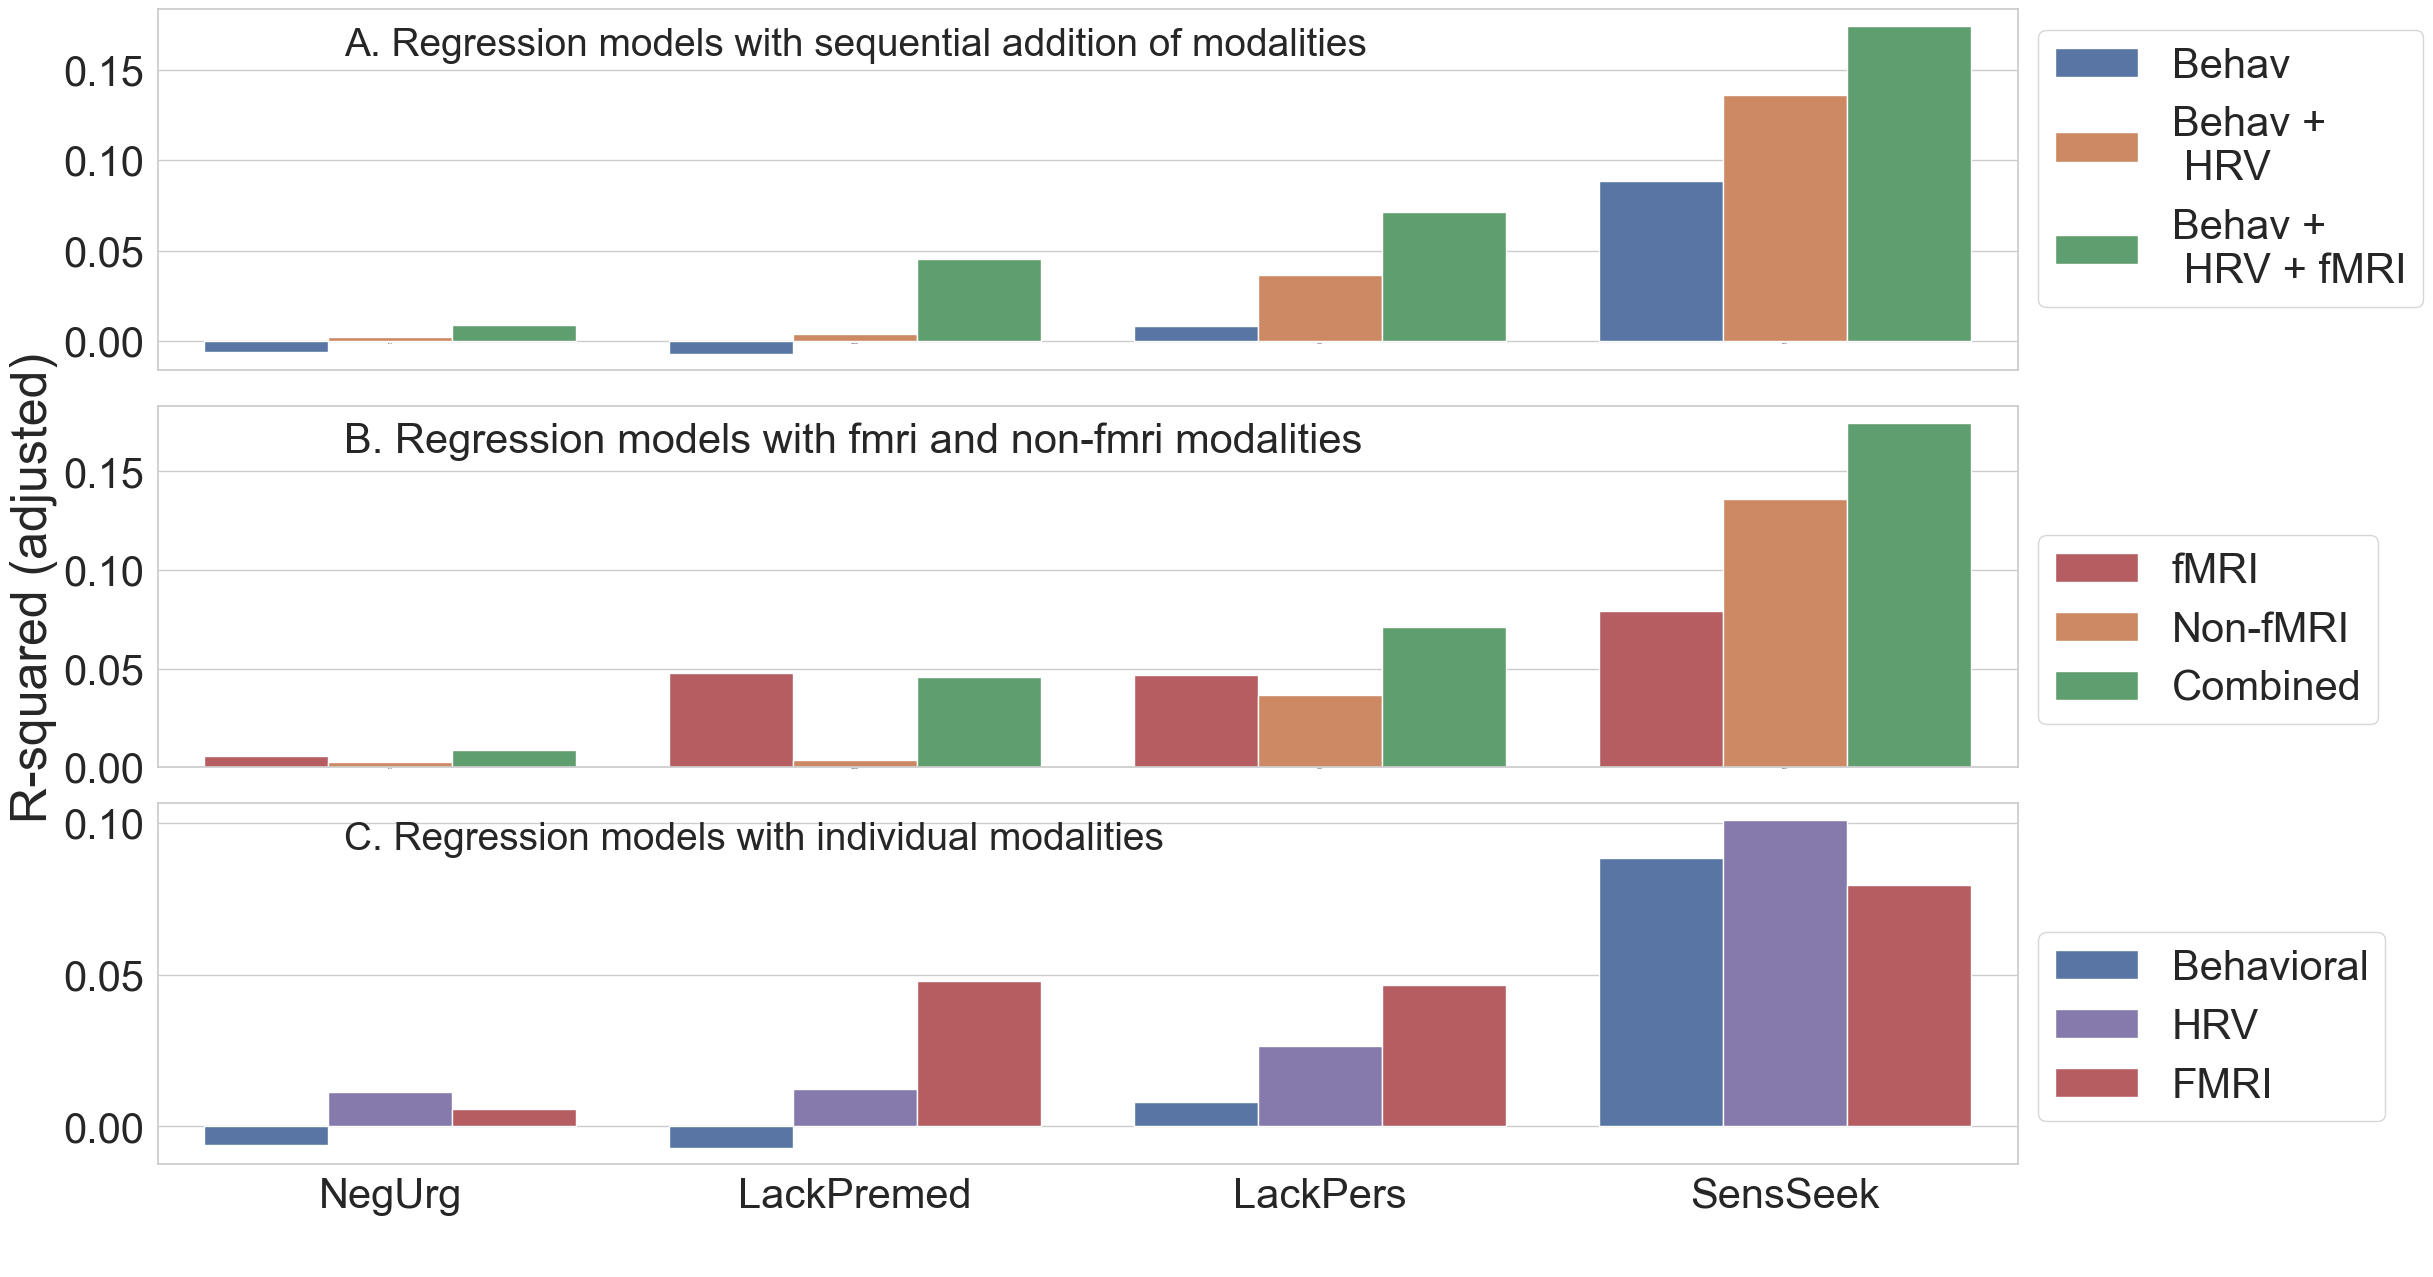

In [33]:
x_loc_title, y_loc_title = 0.1, 0.85
title_loc = 'left'

def_color_palette = iter(sns.color_palette())
plot_colors_all = OrderedDict()

sns.set(font_scale=3,style='whitegrid')

fig = plt.figure(figsize=(24,15))
gs  = GridSpec(3,1,figure=fig)

#top panel
ax1 = fig.add_subplot(gs[0])
#bottom left panel
ax2 = fig.add_subplot(gs[1])
#bottom right panel
ax3 = fig.add_subplot(gs[2])

#top panel :- sequentially add modality based on cost/complexity
sel_feat_start_sel = ['behav', 'behav_hrv','behav_hrv_neuro']

sel_result     = all_ols_results_pd[all_ols_results_pd.modality.\
                                    isin(sel_feat_start_sel)].copy()

sel_result_map = {'behav':'Behav',
                  'behav_hrv':'Behav + \n HRV',
                  'behav_hrv_neuro':'Behav + \n HRV + fMRI'}

sel_result['feats']    = sel_result['modality'].apply(lambda x:sel_result_map[x])
sel_feat_start_sel_map = [sel_result_map[x] for x in sel_feat_start_sel]

#skip a color since we want similar mapping in lemon - mind2
sequential_modality_color_plot = []
for each_key in sel_feat_start_sel_map:
    curr_color = next(def_color_palette)
    sequential_modality_color_plot.append(curr_color)
    plot_colors_all[each_key] = curr_color

sns.barplot(x='label',y='rsquared_adj',hue='feats',data=sel_result,ax=ax1,
           hue_order=sel_feat_start_sel_map,palette=sequential_modality_color_plot)

ax1.set_ylabel(' ')
ax1.set_xlabel(' ')
ax1.tick_params(axis="x",direction="in", pad=-20,labelsize=0)
ax1.tick_params(axis='y', which='major', labelsize=30)
ax1.legend(ncol=1,fontsize=30,  bbox_to_anchor=(1,1.0),bbox_transform=ax1.transAxes) 
ax1.set_title('A. Regression models with sequential addition of modalities',fontsize=28,x=x_loc_title,y=y_loc_title,
             loc=title_loc)


#### -----------------

#left panel :- fmri vs non-fmri modalities
sel_feat_start_sel = ['neuro','behav_hrv','behav_hrv_neuro']
sel_result         = all_ols_results_pd[all_ols_results_pd.modality.\
                                    isin(sel_feat_start_sel)].copy()
sel_result['feats'] = sel_result['modality'].apply(lambda x:{'neuro':'fMRI',
                                'behav_hrv':'Non-fMRI',
                           'behav_hrv_neuro':'Combined'}[x])

fmri_nonFmri_color = [next(def_color_palette),sequential_modality_color_plot[1],
                      sequential_modality_color_plot[2]]

sns.barplot(x='label',y='rsquared_adj',hue='feats',data=sel_result,ax=ax2,palette=fmri_nonFmri_color)

ax2.set_ylabel(' ')
ax2.set_xlabel(' ')
ax2.legend(ncol=1,fontsize=30,
          bbox_transform=ax2.transAxes, bbox_to_anchor=(1.0,0.7)) 

ax2.tick_params(axis="x",direction="in", pad=0,labelsize=0)
ax2.tick_params(axis='y', which='major', labelsize=30)
ax2.set_title('B. Regression models with fmri and non-fmri modalities',fontsize=30,
             x=x_loc_title,y=y_loc_title,loc=title_loc)


#comparison of all modalities

sel_feat_start_sel = ['behav','hrv','neuro'] #['HRV','FMRI','HRV_FMRI']

sel_result     = all_ols_results_pd[(all_ols_results_pd.modality.isin(sel_feat_start_sel))].copy()

indiv_modality_palette = [sequential_modality_color_plot[0],
                          next(def_color_palette),
                         fmri_nonFmri_color[0]]

sel_result['feats'] = sel_result['modality'].apply(lambda x:{'neuro':'FMRI',
                                'hrv':'HRV',
                           'behav':'Behavioral'}[x])

sns.barplot(x='label',y='rsquared_adj',hue='feats',
            data=sel_result,ax=ax3,palette=indiv_modality_palette)

ax3.set_ylabel(' ')
ax3.set_xlabel(' ')
ax3.tick_params('x', labelrotation=0,labelsize=30) 
ax3.get_legend().remove()
ax3.legend(ncol=1,fontsize=30,bbox_transform=ax3.transAxes,
           bbox_to_anchor=(1.0,0.7)) 
ax3.tick_params(axis='y', which='major', labelsize=30)
ax3.set_title('C. Regression models with individual modalities',
              fontsize=28,x=x_loc_title,y=y_loc_title,loc=title_loc)

plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=-0)

ax2.set_ylabel('R-squared (adjusted)',fontsize=36)



### out-of-sample prediction

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, LeaveOneOut
from sklearn.linear_model import RidgeCV, Ridge, Lasso, LassoCV
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [35]:
loo_split = LeaveOneOut()

In [36]:
lin_svr   = SVR(kernel='linear')

In [37]:
minmax_scaler    = MinMaxScaler()
standard_scaler  = StandardScaler()

In [38]:
kfold_split = KFold(n_splits=5)

In [39]:
multimodal_feat_upps.shape

(165, 180)

In [40]:
feat_modality = OrderedDict({'behav':all_behav_feat,
                            'hrv':all_hrv_feat,
                            'neuro':all_neuro_feat})

all_pred_results = []
sel_model        = lin_svr

all_true_pred = []

for each_cols in all_upps_cols:
    label_data = multimodal_feat_upps[each_cols].copy()
    
    label_numquest = quest_cols_numquest[each_cols]
    
    for modality in [['behav','hrv','neuro']]:
        
        sel_feat = []
        for each_mod in modality:
            sel_feat = sel_feat + feat_modality[each_mod]
        
        #add demographics
        sel_feat = sel_feat + ['avg_age','Gender']
        
        feat_data  = multimodal_feat_upps[sel_feat].copy()
        
        all_label_true = []
        all_label_pred = []
        
        for train_idx, test_idx in kfold_split.split(feat_data,label_data):
            train_feat, test_feat   = feat_data.iloc[train_idx,:], feat_data.iloc[test_idx,:]
            train_label, test_label = label_data.iloc[train_idx], label_data.iloc[test_idx]
            
            
            train_feat = minmax_scaler.fit_transform(train_feat)
            test_feat  = minmax_scaler.transform(test_feat)
            
            sel_model.fit(train_feat,train_label)
            pred_label = sel_model.predict(test_feat)
            
            
            #maximum/minimum of the questionnaire
            pred_label = np.array([np.max([x,  label_numquest*1]) for x in pred_label])
            pred_label = np.array([np.min([x, label_numquest*4]) for x in pred_label]) 

            all_label_true.append(test_label)
            all_label_pred.append(pred_label)
            
        all_label_true_np = np.concatenate(all_label_true)
        all_label_pred_np = np.concatenate(all_label_pred)
        
        all_true_pred.append({'col':each_cols,'modality':'_'.join(modality),
                             'true':all_label_true_np,'pred':all_label_pred_np})
 
        rmse_curr = np.sqrt(mean_squared_error(all_label_true_np,all_label_pred_np))
        corr_val, corr_pval = pearsonr(all_label_true_np,all_label_pred_np)
    
        nrmse_curr = rmse_curr/(np.max(all_label_true_np) - np.min(all_label_true_np))
        
        all_pred_results.append({'upps':each_cols,
                               'modality':'_'.join(modality),
                               'rmse':rmse_curr,
                               'nrmse':nrmse_curr,
                                'corr':corr_val,
                                'corr_pval':corr_pval})
    
    meanbaseline_rmse_curr = np.sqrt(mean_squared_error(all_label_true_np,
                                                    np.mean(all_label_true_np)*np.ones_like(all_label_true_np)))
    
    meanbaseline_nrmse_curr = meanbaseline_rmse_curr/(np.max(all_label_true_np) - np.min(all_label_true_np))
        
    all_pred_results.append({'upps':each_cols,
                               'modality':'mean_baseline',
                               'rmse':meanbaseline_rmse_curr,
                               'nrmse':meanbaseline_nrmse_curr,
                            'corr':np.nan,
                             'corr_pval':1.0})

In [41]:
all_pred_results_pd = pd.DataFrame(all_pred_results)

In [42]:
all_true_pred_pd = pd.DataFrame(all_true_pred)

In [43]:
all_pred_results_pd[all_pred_results_pd.modality=='behav_hrv_neuro']

,upps,modality,rmse,nrmse,corr,corr_pval
0,UPPS_urgency,behav_hrv_neuro,5.004359,0.217581,-0.011683,8.816094e-01
2,UPPS_lack_premeditation,behav_hrv_neuro,4.551280,0.197882,-0.202742,9.010781e-03
4,UPPS_lack_perseverance,behav_hrv_neuro,4.813011,0.200542,0.185065,1.732536e-02
6,UPPS_sens_seek,behav_hrv_neuro,5.866532,0.183329,0.487454,3.137244e-11
